# Credit Card Fraud – Anomaly Detection & Explainability

## Dependencies

In [ ]:
%pip -q install numpy pandas joblib cloudpickle matplotlib seaborn shap lime scikit-learn

print("All dependencies for Isolation Forest installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
All dependencies for Isolation Forest installed


## Imports

In [ ]:
import os
import json
import joblib
import cloudpickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from pathlib import Path

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from matplotlib.colors import LinearSegmentedColormap
from scipy.sparse import issparse, load_npz

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Parameters

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 42
RESULTS_DIR = Path('/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams')

TRAIN_SAMPLE_SIZE = 30000

N_FRAUD_SAMPLES = 50
N_NORMAL_SAMPLES = 150

BACKGROUND_SIZE = 500
SHAP_KMEANS_K = 100

LIME_NUM_SAMPLES = 5000
LIME_KERNEL_WIDTH = 7.5
LIME_NUM_FEATURES = 15

SHAP_NSAMPLES = 2048

Mounted at /content/drive


## Loading Data

In [ ]:
import numpy as np
from pathlib import Path

PREPROCESSOR_TYPE = 'kernel'

def load_features(data_dir, preprocessor_type, data_name):
    """Loads pre-computed features, handling both sparse and dense formats."""
    base_path = data_dir / f"{data_name}_{preprocessor_type}"
    path_npz = base_path.with_suffix('.npz')
    path_npy = base_path.with_suffix('.npy')

    if path_npz.exists():
        return load_npz(path_npz)
    elif path_npy.exists():
        return np.load(path_npy)
    else:
        raise FileNotFoundError(f"Data not found for {base_path}")

# Paths
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/processed_data")
preprocessor_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors")

print(f"--- Loading data for '{PREPROCESSOR_TYPE}' preprocessor ---")

X_train = load_features(data_dir, PREPROCESSOR_TYPE, 'X_train_transformed')
X_test  = load_features(data_dir, PREPROCESSOR_TYPE, 'X_test_transformed')
y_train = np.load(data_dir / "y_train.npy")
y_test  = np.load(data_dir / "y_test.npy")

print("Data loaded successfully.")
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

--- Loading data for 'kernel' preprocessor ---
Data loaded successfully.
X_train shape: (978768, 165)
X_test  shape: (244692, 165)


## Local Outlier Factor Model

### Hyperparameters

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Utility to convert to dense
def to_dense(data):
    return data.toarray() if issparse(data) else data

MAX_TUNE_TOTAL = 20000
NORMALS_PER_POS = 3
N_FOLDS = 3
param_grid = {
    "n_neighbors": [15, 30],
    "leaf_size": [30],
    "metric": ["minkowski"],
    "p": [2]
}

y_arr = np.asarray(y_train).astype(int)
pos_idx = np.where(y_arr == 1)[0]
neg_idx = np.where(y_arr == 0)[0]

n_pos = len(pos_idx)
n_neg = min(len(neg_idx), max(5000, min(NORMALS_PER_POS * n_pos, MAX_TUNE_TOTAL - n_pos)))
rng = np.random.default_rng(RANDOM_STATE)
neg_sample = rng.choice(neg_idx, size=n_neg, replace=False) if n_neg > 0 else np.array([], dtype=int)

tune_idx = np.concatenate([pos_idx, neg_sample])
rng.shuffle(tune_idx)

X_tune = to_dense(X_train[tune_idx])
y_tune = y_arr[tune_idx]

print(f"Tuning subset shapes -> X: {X_tune.shape}, y: {y_tune.shape}, positives: {y_tune.sum()}")

def lof_cv_auc(X, y, params, n_splits=N_FOLDS, random_state=RANDOM_STATE):
    """
    Semi-supervised CV for LOF:
    - Fit on normals-only in training fold
    - Score validation fold with ROC-AUC on -score_samples
    """
    y = np.asarray(y).astype(int)
    n_pos = int(np.sum(y == 1))
    if n_pos < 2:
        n_splits = 2
    else:
        n_splits = min(n_splits, max(2, n_pos))

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aucs = []
    for tr_idx, va_idx in cv.split(X, y):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        X_tr_normals = X_tr[y_tr == 0]
        lof = LocalOutlierFactor(
            novelty=True,
            n_neighbors=params.get("n_neighbors", 20),
            leaf_size=params.get("leaf_size", 30),
            metric=params.get("metric", "minkowski"),
            p=params.get("p", 2),
            contamination=y.mean()  # thresholding only; AUC is threshold-free
        )
        lof.fit(X_tr_normals)
        scores = -lof.score_samples(X_va)
        try:
            aucs.append(roc_auc_score(y_va, scores))
        except Exception:
            pass

    return float(np.mean(aucs)) if aucs else 0.5

print("Starting FAST LOF hyperparameter tuning (semi-supervised CV)...")
best_params, best_score = None, -np.inf
for n_nb in param_grid["n_neighbors"]:
    for leaf in param_grid["leaf_size"]:
        for p in param_grid["p"]:
            params = {"n_neighbors": n_nb, "leaf_size": leaf, "metric": "minkowski", "p": p}
            auc = lof_cv_auc(X_tune, y_tune, params)
            print(f"Params {params} -> CV ROC-AUC: {auc:.4f}")
            if auc > best_score:
                best_score, best_params = auc, params

TUNED_PARAMS = best_params
print("Best LOF params:", TUNED_PARAMS)
print("Best CV ROC-AUC:", best_score)

Tuning subset shapes -> X: (11872, 165), y: (11872,), positives: 2968
Starting FAST LOF hyperparameter tuning (semi-supervised CV)...
Params {'n_neighbors': 15, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV ROC-AUC: 0.7156
Params {'n_neighbors': 30, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} -> CV ROC-AUC: 0.6756
Best LOF params: {'n_neighbors': 15, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2}
Best CV ROC-AUC: 0.7156046611788547


## Train and Evaluate

--- Training LOF (novelty) on 15000 sampled normals ---
Training Local Outlier Factor with params: {'n_neighbors': 15, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} (contamination=0.0030)

Trained Full LOF Model saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lof_full_kernel.joblib

--- Model Performance (Test Set) ---
Precision: 0.0148
Recall: 0.0148
F1: 0.0148
ROC-AUC: 0.7406
PR-AUC: 0.0089
Threshold: 1.3028


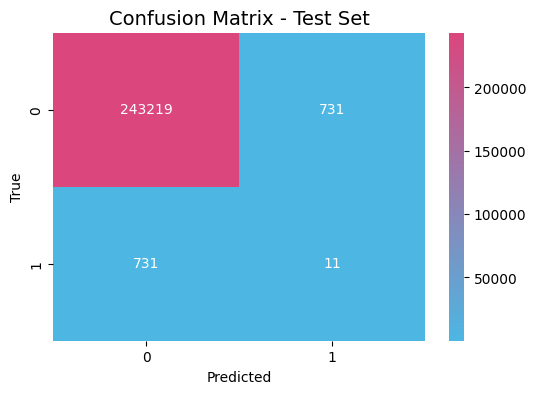

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

CONTAMINATION_RATE = y_train.mean()
custom_cmap = LinearSegmentedColormap.from_list('custom', ['#4db6e3', '#db467d'])

def train_lof(X_train_data, contamination=CONTAMINATION_RATE):
    """Train LOF with tuned hyperparameters (novelty detection)."""
    params = dict(TUNED_PARAMS) if 'TUNED_PARAMS' in globals() else {}
    print(f"Training Local Outlier Factor with params: {params} (contamination={contamination:.4f})")
    model = LocalOutlierFactor(
        novelty=True,
        n_neighbors=params.get('n_neighbors', 20),
        leaf_size=params.get('leaf_size', 30),
        metric=params.get('metric', 'minkowski'),
        p=params.get('p', 2),
        contamination=contamination
    )
    model.fit(to_dense(X_train_data))
    return model

def evaluate_model(model, X, y, contamination=CONTAMINATION_RATE, verbose=False, data_label="Test Set"):
    scores = -model.score_samples(to_dense(X))
    threshold = np.percentile(scores, 100 * (1 - contamination))
    y_pred = (scores >= threshold).astype(int)

    metrics_dict = {
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y, scores),
        'PR-AUC': average_precision_score(y, scores),
        'Threshold': float(threshold)
    }

    if verbose:
        print(f"\n--- Model Performance ({data_label}) ---")
        for k, v in metrics_dict.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
        plt.title(f'Confusion Matrix - {data_label}', fontsize=14)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return y_pred, metrics_dict, scores

# use fewer normals for training (novelty)
np.random.seed(RANDOM_STATE)
idx_train_normal = np.where(y_train == 0)[0]
EFFECTIVE_TRAIN_SAMPLE = min(15000, len(idx_train_normal))
train_indices = np.random.choice(idx_train_normal, EFFECTIVE_TRAIN_SAMPLE, replace=False)
X_train_sample = X_train[train_indices]

print(f"--- Training LOF (novelty) on {EFFECTIVE_TRAIN_SAMPLE} sampled normals ---")
lof_model_full = train_lof(to_dense(X_train_sample))

output_dir = Path("/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model")
output_dir.mkdir(parents=True, exist_ok=True)
model_path = output_dir / f"lof_full_{PREPROCESSOR_TYPE}.joblib"
joblib.dump(lof_model_full, model_path)
print(f"\nTrained Full LOF Model saved to: {model_path}")

_ , train_metrics_full, _ = evaluate_model(lof_model_full, X_train, y_train, data_label="Train Set", verbose=False)
_ , test_metrics_full,  _ = evaluate_model(lof_model_full, X_test,  y_test,  data_label="Test Set",  verbose=True)

with open(output_dir / "metrics_train.json", "w") as f:
    json.dump(train_metrics_full, f, indent=2)
with open(output_dir / "metrics_test.json", "w") as f:
    json.dump(test_metrics_full, f, indent=2)
with open(output_dir / "tuned_params.json", "w") as f:
    json.dump({"tuned_params": TUNED_PARAMS, "contamination": float(CONTAMINATION_RATE)}, f, indent=2)

## Build Background & Evaluation Subsets

In [ ]:
rng = np.random.default_rng(RANDOM_STATE)
X_train_dense = to_dense(X_train)
X_test_dense  = to_dense(X_test)

idx_train_normal = np.where(y_train == 0)[0]
idx_train_fraud  = np.where(y_train == 1)[0]

bg_cap = 300
bg_size = int(min(BACKGROUND_SIZE, bg_cap, len(idx_train_normal)))
bg_indices = rng.choice(idx_train_normal, size=bg_size, replace=False)
background_data = X_train_dense[bg_indices]

panel_cap_normal = 120
panel_cap_fraud  = 40
n_fraud  = int(min(N_FRAUD_SAMPLES, panel_cap_fraud, len(idx_train_fraud)))
n_normal = int(min(N_NORMAL_SAMPLES, panel_cap_normal, len(idx_train_normal)))

panel_fraud_idx  = rng.choice(idx_train_fraud,  size=n_fraud,  replace=False)
panel_normal_idx = rng.choice(idx_train_normal, size=n_normal, replace=False)

eval_data   = np.vstack([X_train_dense[panel_fraud_idx], X_train_dense[panel_normal_idx]])
eval_labels = np.concatenate([y_train[panel_fraud_idx], y_train[panel_normal_idx]])

# Save
np.save(output_dir / "background_data.npy", background_data)
np.save(output_dir / "eval_data.npy", eval_data)
np.save(output_dir / "eval_labels.npy", eval_labels)

print("Background and evaluation subsets prepared.",
      f"background_data: {background_data.shape} | eval_data: {eval_data.shape}")

Background and evaluation subsets prepared. background_data: (300, 165) | eval_data: (160, 165)


## Explain with SHAP KernelExplainer

Loading preprocessor 'kernel' from /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/preprocessors/preprocessor_kernel.pkl...
Computing SHAP values on 160 rows with K=50, nsamples=1024...


  0%|          | 0/160 [00:00<?, ?it/s]

SHAP values computed in 1418.69 seconds.


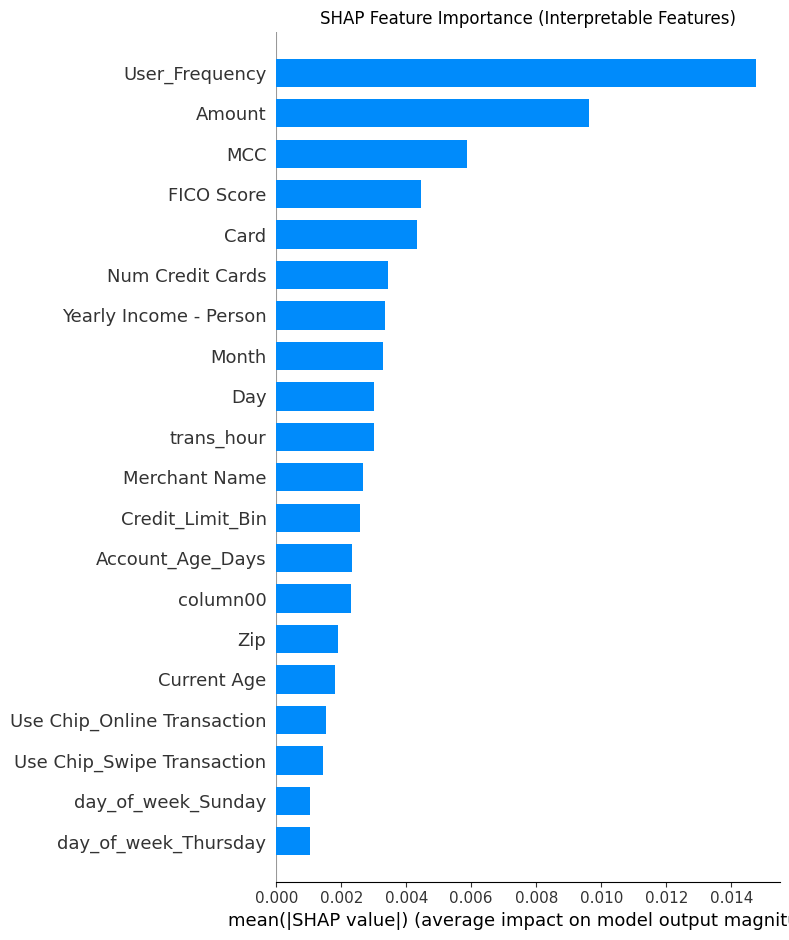

Saved SHAP bar plot to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/shap_plots/shap_summary_bar_lof_full_kernel_interpretable_only.png


In [ ]:
import re, time

preprocessor_file = preprocessor_dir / f"preprocessor_{PREPROCESSOR_TYPE}.pkl"
print(f"Loading preprocessor '{PREPROCESSOR_TYPE}' from {preprocessor_file}...")
with open(preprocessor_file, "rb") as f:
    preprocessor = cloudpickle.load(f)

def get_feature_names_manually(ct, input_dim):
    num_cols = [c for name, trans, c in ct.transformers_ if name == 'num'][0]
    if 'lowc' in ct.named_transformers_:
        lowc_pipeline = ct.named_transformers_['lowc']
        try:
            ohe_names = list(lowc_pipeline.get_feature_names_out())
        except Exception:
            ohe_names = []
    else:
        ohe_names = []
    interpretable_names = num_cols + ohe_names
    n_hashed = input_dim - len(interpretable_names)
    hash_names = [f'hashed_feature_{i}' for i in range(n_hashed)]
    return interpretable_names + hash_names

original_feature_names = get_feature_names_manually(preprocessor, lof_model_full.n_features_in_)

def explain_with_shap_kernel(model, background_summary, eval_data, nsamples):
    explainer = shap.KernelExplainer(lambda x: -model.score_samples(x), background_summary)
    shap_values = explainer.shap_values(to_dense(eval_data), nsamples=nsamples)
    return explainer, np.array(shap_values)

K_EFF = min(SHAP_KMEANS_K, 50)
NSAMPLES_EFF = min(1024, SHAP_NSAMPLES)
MAX_EVAL_FOR_SHAP = 200

background_summary = shap.kmeans(to_dense(background_data), K_EFF)

eval_data_shap = eval_data[:MAX_EVAL_FOR_SHAP]

print(f"Computing SHAP values on {eval_data_shap.shape[0]} rows with K={K_EFF}, nsamples={NSAMPLES_EFF}...")
start_time = time.time()
explainer_lof_full, shap_values_lof_full = explain_with_shap_kernel(
    model=lof_model_full,
    background_summary=background_summary,
    eval_data=eval_data_shap,
    nsamples=NSAMPLES_EFF
)
end_time = time.time()
print(f"SHAP values computed in {end_time - start_time:.2f} seconds.")

clean_feature_names = [re.sub(r'^(num|lowc|highc)__', '', name) for name in original_feature_names]
is_not_hashed_mask = [not name.startswith('hashed_feature') for name in clean_feature_names]
feature_names_for_plot = np.array(clean_feature_names)[is_not_hashed_mask].tolist()
shap_values_for_plot = shap_values_lof_full[:, is_not_hashed_mask]
eval_data_for_plot = to_dense(eval_data_shap)[:, is_not_hashed_mask]

np.save(output_dir / "shap_values_lof_full.npy", shap_values_lof_full)

shap_dir = output_dir / "shap_plots"
shap_dir.mkdir(parents=True, exist_ok=True)
plot_path = shap_dir / f"shap_summary_bar_lof_full_{PREPROCESSOR_TYPE}_interpretable_only.png"

plt.figure()
shap.summary_plot(shap_values_for_plot, features=eval_data_for_plot, feature_names=feature_names_for_plot, plot_type='bar', show=False)
plt.title(f"SHAP Feature Importance (Interpretable Features)")
plt.tight_layout()
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved SHAP bar plot to: {plot_path}")

## Explain with LIME TabularExplainer

In [ ]:
from IPython.display import display, HTML

def lime_predict_proba_lof(model, instances):
    scores = -model.score_samples(to_dense(instances))
    temp = np.vstack([np.zeros_like(scores), scores]).T
    expvals = np.exp(temp - np.max(temp, axis=1, keepdims=True))
    probs = expvals / np.sum(expvals, axis=1, keepdims=True)
    return probs

def explain_with_lime_lof(model, background_data, eval_instance, clean_feats, random_state=RANDOM_STATE,
                          num_features=LIME_NUM_FEATURES, num_samples=2000):
    LIME_BG_CAP = 2000
    bg = to_dense(background_data)
    if bg.shape[0] > LIME_BG_CAP:
        rng = np.random.default_rng(random_state)
        bg_idx = rng.choice(np.arange(bg.shape[0]), size=LIME_BG_CAP, replace=False)
        bg = bg[bg_idx]

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=bg,
        feature_names=clean_feats,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        kernel_width=LIME_KERNEL_WIDTH,
        discretize_continuous=True,
        random_state=random_state
    )
    predict_fn = lambda x: lime_predict_proba_lof(model, x)
    explanation = lime_explainer.explain_instance(
        data_row=to_dense(eval_instance),
        predict_fn=predict_fn,
        num_features=num_features,
        num_samples=num_samples
    )
    return explanation

background_data_dense = to_dense(background_data)
eval_data_dense = to_dense(eval_data)

N_EXAMPLES = min(3, eval_data_dense.shape[0])
LIME_SAMPLES_EFF = min(2000, LIME_NUM_SAMPLES)

for i in range(N_EXAMPLES):
    instance = eval_data_dense[i]
    true_label = "Fraud" if eval_labels[i] == 1 else "Normal"
    print(f"Generating LIME explanation for eval instance #{i} (True: {true_label})")
    lime_exp = explain_with_lime_lof(
        model=lof_model_full,
        background_data=background_data_dense,
        eval_instance=instance,
        clean_feats=clean_feature_names,
        num_features=min(10, LIME_NUM_FEATURES),
        num_samples=LIME_SAMPLES_EFF
    )

    lime_dir = output_dir / "lime_plots"
    lime_dir.mkdir(parents=True, exist_ok=True)
    file_path = lime_dir / f"lime_explanation_lof_full_{PREPROCESSOR_TYPE}_instance_{i}.html"
    html_explanation = lime_exp.as_html()
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(html_explanation)
    print(f"LIME explanation saved to: {file_path}")

print("LIME explanations generated (subset).")

Generating LIME explanation for eval instance #0 (True: Fraud)
LIME explanation saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lime_plots/lime_explanation_lof_full_kernel_instance_0.html
Generating LIME explanation for eval instance #1 (True: Fraud)
LIME explanation saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lime_plots/lime_explanation_lof_full_kernel_instance_1.html
Generating LIME explanation for eval instance #2 (True: Fraud)
LIME explanation saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lime_plots/lime_explanation_lof_full_kernel_instance_2.html
LIME explanations generated (subset).


## LIME Stability Test

In [ ]:
import itertools
from statistics import mean, pstdev

def extract_topk_from_lime(exp, label=1, k=8):
    amap = dict(exp.as_map())
    if label not in amap:
        return set()
    items = amap[label]
    top = sorted(items, key=lambda t: abs(t[1]), reverse=True)[:k]
    return set(idx for idx, w in top)

def lime_explain_with_seed(x, seed, num_features=8, num_samples=1500):
    return explain_with_lime_lof(
        model=lof_model_full,
        background_data=background_data_dense,
        eval_instance=x,
        clean_feats=clean_feature_names,
        random_state=seed,
        num_features=num_features,
        num_samples=num_samples
    )

def jaccard(a, b):
    if not a and not b: return 1.0
    if not a or not b:  return 0.0
    return len(a & b) / len(a | b)

STAB_N_INSTANCES = min(5, eval_data.shape[0])
STAB_RUNS_PER_INSTANCE = 4
TOPK = 8

rng = np.random.default_rng(RANDOM_STATE)
sel_indices = rng.choice(np.arange(eval_data.shape[0]), size=STAB_N_INSTANCES, replace=False)

per_instance_stability = []
instance_details = []

for idx in sel_indices:
    x = eval_data[idx]
    sets = []
    seeds = list(range(1000, 1000 + STAB_RUNS_PER_INSTANCE))
    for sd in seeds:
        exp = lime_explain_with_seed(x, sd, num_features=TOPK, num_samples=1500)
        s = extract_topk_from_lime(exp, label=1, k=TOPK)
        sets.append(s)
    overlaps = [jaccard(sets[i], sets[j]) for i, j in itertools.combinations(range(len(sets)), 2)]
    stab_score = float(mean(overlaps)) if overlaps else 0.0
    per_instance_stability.append(stab_score)
    instance_details.append({"panel_index": int(idx), "stability_topk_jaccard": stab_score, "runs": len(sets), "topk": TOPK})

lime_stability_summary = {
    "mean_stability_topk_jaccard": float(mean(per_instance_stability)) if per_instance_stability else 0.0,
    "std_stability_topk_jaccard": float(pstdev(per_instance_stability)) if len(per_instance_stability) > 1 else 0.0,
    "n_instances": int(STAB_N_INSTANCES),
    "runs_per_instance": int(STAB_RUNS_PER_INSTANCE),
    "topk": int(TOPK)
}

with open(output_dir / "lime_stability_summary.json", "w") as f:
    json.dump(lime_stability_summary, f, indent=2)

pd.DataFrame(instance_details).to_csv(output_dir / "lime_stability_per_instance.csv", index=False)

print("LIME stability test complete (reduced runs).")
print("Summary:", lime_stability_summary)

LIME stability test complete (reduced runs).
Summary: {'mean_stability_topk_jaccard': 0.10449328449328449, 'std_stability_topk_jaccard': 0.059043074203155584, 'n_instances': 5, 'runs_per_instance': 4, 'topk': 8}


## Interpretable Model

In [ ]:
print("--- Training Interpretable-Only LOF Model ---")

is_interpretable_mask = [not name.startswith('hashed_feature') for name in original_feature_names]
interpretable_feature_names = np.array(clean_feature_names)[is_interpretable_mask].tolist()

X_train_sample_interpretable = to_dense(X_train_sample)[:, is_interpretable_mask]

print(f"Number of interpretable features: {X_train_sample_interpretable.shape[1]}")

lof_model_interpretable = train_lof(
    X_train_sample_interpretable
)

output_dir.mkdir(parents=True, exist_ok=True)
model_path_interp = output_dir / f"lof_interpretable_{PREPROCESSOR_TYPE}.joblib"
joblib.dump(lof_model_interpretable, model_path_interp)

print(f"Interpretable LOF model trained and saved to {model_path_interp}.")

from IPython.display import display, HTML
import lime
import lime.lime_tabular

def explain_with_lime(model, background_data, eval_instance, clean_feats, random_state=RANDOM_STATE,
                      num_features=LIME_NUM_FEATURES, num_samples=LIME_NUM_SAMPLES):
    LIME_BG_CAP = 2000
    bg = to_dense(background_data)
    if bg.shape[0] > LIME_BG_CAP:
        rng = np.random.default_rng(random_state)
        bg_idx = rng.choice(np.arange(bg.shape[0]), size=LIME_BG_CAP, replace=False)
        bg = bg[bg_idx]

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=bg,
        feature_names=clean_feats,
        class_names=['Normal', 'Fraud'],
        mode='classification',
        kernel_width=LIME_KERNEL_WIDTH,
        discretize_continuous=True,
        random_state=random_state
    )

    predict_fn = lambda x: lime_predict_proba_lof(model, x)

    explanation = lime_explainer.explain_instance(
        data_row=to_dense(eval_instance),
        predict_fn=predict_fn,
        num_features=min(10, num_features),         # cap for speed
        num_samples=min(2000, num_samples)          # cap for speed
    )
    return explanation

background_data_interpretable = to_dense(background_data)[:, is_interpretable_mask]
eval_data_interpretable = to_dense(eval_data)[:, is_interpretable_mask]

INSTANCE_INDEX_TO_EXPLAIN = 5 if eval_data_interpretable.shape[0] > 5 else 0
instance_to_explain_interpretable = eval_data_interpretable[INSTANCE_INDEX_TO_EXPLAIN]
true_label = "Fraud" if eval_labels[INSTANCE_INDEX_TO_EXPLAIN] == 1 else "Normal"

print(f"Generating LIME explanation for instance #{INSTANCE_INDEX_TO_EXPLAIN} (True Label: {true_label}) using the interpretable model.")

lime_explanation_lof_interpretable = explain_with_lime(
    model=lof_model_interpretable,  # Use the interpretable model
    background_data=background_data_interpretable,
    eval_instance=instance_to_explain_interpretable,
    clean_feats=interpretable_feature_names
)

lime_dir = output_dir / "lime_plots"
lime_dir.mkdir(parents=True, exist_ok=True)
file_path = lime_dir / f"lime_explanation_lof_interpretable_{PREPROCESSOR_TYPE}_instance_{INSTANCE_INDEX_TO_EXPLAIN}.html"

html_explanation = lime_explanation_lof_interpretable.as_html()
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(html_explanation)

print(f"\nLIME explanation for interpretable model saved to: {file_path}")
display(HTML(html_explanation))

print("--- Running LIME Stability Test for Interpretable Model ---")

import re
from itertools import combinations

N_STABILITY_RUNS = 4
TOP_K_FEATURES   = 8

top_k_feature_sets_interpretable = []
for i in range(N_STABILITY_RUNS):
    current_seed = RANDOM_STATE + i

    instance_to_test_interpretable = eval_data_interpretable[INSTANCE_INDEX_TO_EXPLAIN]

    explanation = explain_with_lime(
        model=lof_model_interpretable,
        background_data=background_data_interpretable,
        eval_instance=instance_to_test_interpretable,
        clean_feats=interpretable_feature_names,
        random_state=current_seed,
        num_features=TOP_K_FEATURES,
        num_samples=min(2000, LIME_NUM_SAMPLES)
    )

    try:
        top_pairs = explanation.as_list(label=1)[:TOP_K_FEATURES]
    except Exception:
        top_pairs = explanation.as_list()[:TOP_K_FEATURES]
    top_features = {re.split(r' [<>]=? ', feature)[0] for feature, weight in top_pairs}
    top_k_feature_sets_interpretable.append(top_features)
    print(f"  Run {i+1} (seed {current_seed}) Top {TOP_K_FEATURES} interpretable features: {sorted(list(top_features))}")

if len(top_k_feature_sets_interpretable) > 1:
    jaccard_scores_interp = []
    for set1, set2 in combinations(top_k_feature_sets_interpretable, 2):
        intersection_size = len(set1.intersection(set2))
        union_size = len(set1.union(set2))
        if union_size > 0:
            jaccard_scores_interp.append(intersection_size / union_size)

    average_jaccard_score_interp = np.mean(jaccard_scores_interp) if jaccard_scores_interp else 0.0
    print(f"\nAverage Jaccard Similarity (Interpretable Model): {average_jaccard_score_interp:.4f}")
    if average_jaccard_score_interp >= 0.7:
        print("Result: This indicates a HIGHLY STABLE explanation.")
    elif average_jaccard_score_interp >= 0.5:
        print("Result: This indicates a MODERATELY STABLE explanation.")
    else:
        print("Result: This indicates LOW STABILITY.")
else:
    print("\nCannot calculate stability with fewer than 2 runs.")

--- Training Interpretable-Only LOF Model ---
Number of interpretable features: 36
Training Local Outlier Factor with params: {'n_neighbors': 15, 'leaf_size': 30, 'metric': 'minkowski', 'p': 2} (contamination=0.0030)
Interpretable LOF model trained and saved to /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lof_interpretable_kernel.joblib.
Generating LIME explanation for instance #5 (True Label: Fraud) using the interpretable model.

LIME explanation for interpretable model saved to: /content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/local_outlier_factor_model/lime_plots/lime_explanation_lof_interpretable_kernel_instance_5.html


--- Running LIME Stability Test for Interpretable Model ---
  Run 1 (seed 42) Top 8 interpretable features: ['-0.22', 'Amount', 'Card Brand_Amex', 'Card Type_Debit (Prepaid)', 'Use Chip_Online Transaction', 'Yearly Income - Person', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
  Run 2 (seed 43) Top 8 interpretable features: ['Amount', 'Card Brand_Amex', 'Card Brand_Discover', 'Card Type_Debit (Prepaid)', 'Use Chip_Online Transaction', 'Yearly Income - Person', 'day_of_week_Saturday', 'day_of_week_Tuesday']
  Run 3 (seed 44) Top 8 interpretable features: ['-0.22', 'Amount', 'Card Brand_Amex', 'Card Type_Debit (Prepaid)', 'Use Chip_Online Transaction', 'Yearly Income - Person', 'day_of_week_Sunday', 'day_of_week_Wednesday']
  Run 4 (seed 45) Top 8 interpretable features: ['Amount', 'Card Brand_Amex', 'Card Type_Debit (Prepaid)', 'Yearly Income - Person', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Tuesday']

Average Jaccard Similarity (Interpretabl

## Interpretability Metrics

  0%|          | 0/160 [00:00<?, ?it/s]

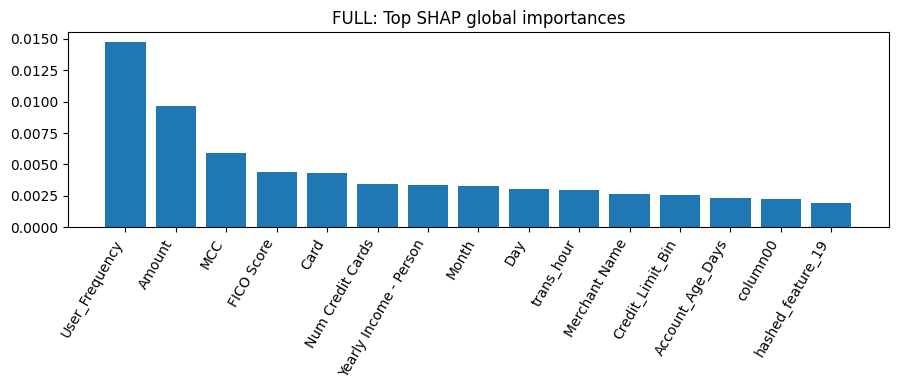

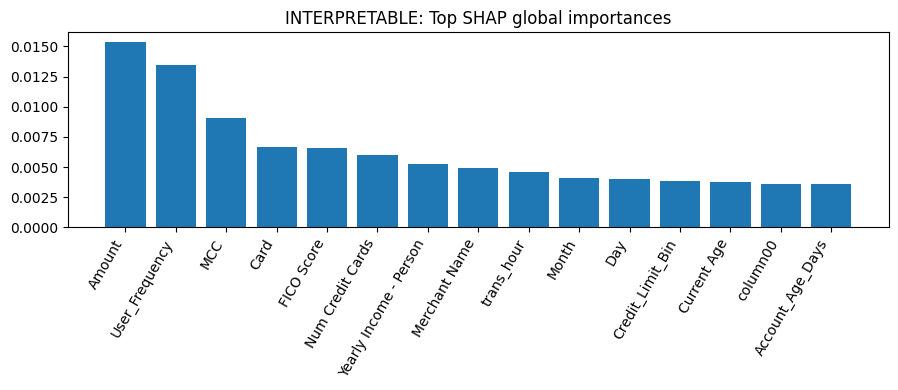

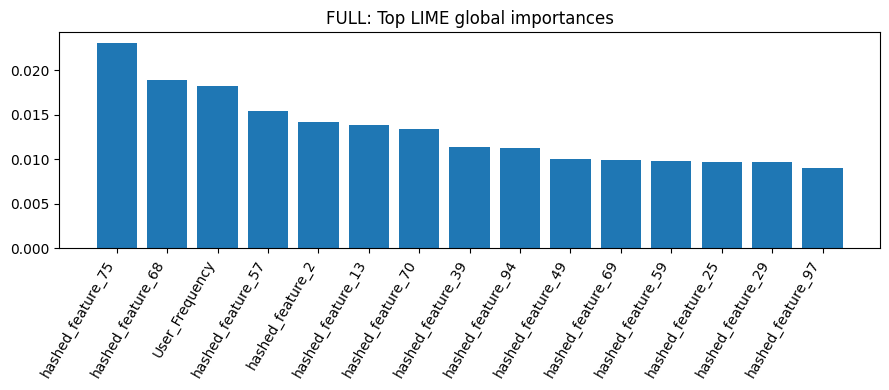

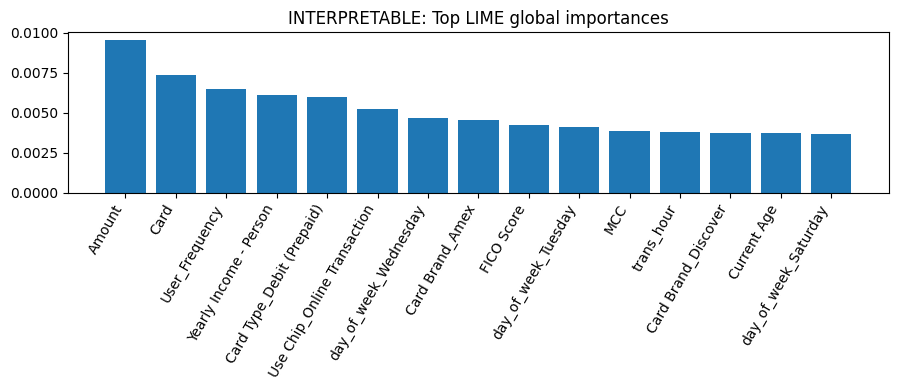

Saved interpretability tables & plots for both FULL and INTERPRETABLE models.


In [ ]:
from collections import defaultdict

def ensure_array(values):
    if isinstance(values, list): values = values[0]
    return np.asarray(values)

try:
    K_EFF
except NameError:
    K_EFF = min(SHAP_KMEANS_K, 50)
try:
    NSAMPLES_EFF
except NameError:
    NSAMPLES_EFF = min(1024, SHAP_NSAMPLES)
try:
    MAX_EVAL_FOR_SHAP
except NameError:
    MAX_EVAL_FOR_SHAP = 200

shap_vals_full = ensure_array(shap_values_lof_full)
shap_global_full = np.mean(np.abs(shap_vals_full), axis=0)

df_shap_global_full = pd.DataFrame({
    "feature": clean_feature_names,
    "mean_abs_shap": shap_global_full
}).sort_values("mean_abs_shap", ascending=False)
df_shap_global_full.to_csv(output_dir / "global_importance_shap_full.csv", index=False)

N_LIME_GLOBAL_FULL = min(20, eval_data.shape[0])
lime_weights_full = defaultdict(list)

for i in range(N_LIME_GLOBAL_FULL):
    x_i = eval_data[i]
    exp = explain_with_lime_lof(
        model=lof_model_full,
        background_data=background_data,
        eval_instance=x_i,
        clean_feats=clean_feature_names,
        num_features=min(10, LIME_NUM_FEATURES),
        num_samples=min(2000, LIME_NUM_SAMPLES)
    )
    amap = dict(exp.as_map())
    if 1 in amap:
        for feat_idx, w in amap[1]:
            lime_weights_full[feat_idx].append(abs(w))

lime_global_full = np.zeros(len(clean_feature_names))
for feat_idx, ws in lime_weights_full.items():
    lime_global_full[feat_idx] = float(np.mean(ws))

df_lime_global_full = pd.DataFrame({
    "feature": clean_feature_names,
    "mean_abs_lime_weight": lime_global_full
}).sort_values("mean_abs_lime_weight", ascending=False)
df_lime_global_full.to_csv(output_dir / "global_importance_lime_full.csv", index=False)

TOPK_IMP = 10
topk_shap_idx_full = set(np.argsort(-shap_global_full)[:TOPK_IMP])
topk_lime_idx_full = set(np.argsort(-lime_global_full)[:TOPK_IMP])
overlap_imp_full = len(topk_shap_idx_full & topk_lime_idx_full) / len(topk_shap_idx_full | topk_lime_idx_full) if (topk_shap_idx_full or topk_lime_idx_full) else 1.0

sparsity_counts_full = []
for i in range(N_LIME_GLOBAL_FULL):
    x_i = eval_data[i]
    exp = explain_with_lime_lof(
        model=lof_model_full,
        background_data=background_data,
        eval_instance=x_i,
        clean_feats=clean_feature_names,
        num_features=min(10, LIME_NUM_FEATURES),
        num_samples=min(2000, LIME_NUM_SAMPLES)
    )
    amap = dict(exp.as_map())
    sparsity_counts_full.append(len(amap.get(1, [])))

interpretability_metrics_full = {
    "topk_global_overlap_jaccard": float(overlap_imp_full),
    "topk_global_k": int(TOPK_IMP),
    "lime_sparsity_mean_nonzero_features": float(np.mean(sparsity_counts_full)) if sparsity_counts_full else 0.0,
    "lime_sparsity_std_nonzero_features": float(np.std(sparsity_counts_full)) if len(sparsity_counts_full) > 1 else 0.0,
    "n_lime_global": int(N_LIME_GLOBAL_FULL),
}
with open(output_dir / "interpretability_metrics_full.json", "w") as f:
    json.dump(interpretability_metrics_full, f, indent=2)

background_summary_interpretable = shap.kmeans(
    background_data_interpretable, min(K_EFF, background_data_interpretable.shape[0])
)
eval_data_shap_interpretable = eval_data_interpretable[:min(MAX_EVAL_FOR_SHAP, eval_data_interpretable.shape[0])]

explainer_interp, shap_values_lof_interpretable = (
    shap.KernelExplainer(lambda x: -lof_model_interpretable.score_samples(x), background_summary_interpretable),
    None
)
shap_values_lof_interpretable = np.array(
    explainer_interp.shap_values(eval_data_shap_interpretable, nsamples=NSAMPLES_EFF)
)

shap_vals_interp = ensure_array(shap_values_lof_interpretable)
shap_global_interp = np.mean(np.abs(shap_vals_interp), axis=0)

df_shap_global_interp = pd.DataFrame({
    "feature": interpretable_feature_names,
    "mean_abs_shap": shap_global_interp
}).sort_values("mean_abs_shap", ascending=False)
df_shap_global_interp.to_csv(output_dir / "global_importance_shap_interpretable.csv", index=False)

N_LIME_GLOBAL_INTERP = min(20, eval_data_interpretable.shape[0])
lime_weights_interp = defaultdict(list)

for i in range(N_LIME_GLOBAL_INTERP):
    x_i = eval_data_interpretable[i]
    exp = explain_with_lime(
        model=lof_model_interpretable,
        background_data=background_data_interpretable,
        eval_instance=x_i,
        clean_feats=interpretable_feature_names,
        num_features=min(10, LIME_NUM_FEATURES),
        num_samples=min(2000, LIME_NUM_SAMPLES)
    )
    amap = dict(exp.as_map())
    if 1 in amap:
        for feat_idx, w in amap[1]:
            lime_weights_interp[feat_idx].append(abs(w))

lime_global_interp = np.zeros(len(interpretable_feature_names))
for feat_idx, ws in lime_weights_interp.items():
    lime_global_interp[feat_idx] = float(np.mean(ws))

df_lime_global_interp = pd.DataFrame({
    "feature": interpretable_feature_names,
    "mean_abs_lime_weight": lime_global_interp
}).sort_values("mean_abs_lime_weight", ascending=False)
df_lime_global_interp.to_csv(output_dir / "global_importance_lime_interpretable.csv", index=False)

topk_shap_idx_interp = set(np.argsort(-shap_global_interp)[:TOPK_IMP])
topk_lime_idx_interp = set(np.argsort(-lime_global_interp)[:TOPK_IMP])
overlap_imp_interp = len(topk_shap_idx_interp & topk_lime_idx_interp) / len(topk_shap_idx_interp | topk_lime_idx_interp) if (topk_shap_idx_interp or topk_lime_idx_interp) else 1.0

sparsity_counts_interp = []
for i in range(N_LIME_GLOBAL_INTERP):
    x_i = eval_data_interpretable[i]
    exp = explain_with_lime(
        model=lof_model_interpretable,
        background_data=background_data_interpretable,
        eval_instance=x_i,
        clean_feats=interpretable_feature_names,
        num_features=min(10, LIME_NUM_FEATURES),
        num_samples=min(2000, LIME_NUM_SAMPLES)
    )
    amap = dict(exp.as_map())
    sparsity_counts_interp.append(len(amap.get(1, [])))

interpretability_metrics_interpretable = {
    "topk_global_overlap_jaccard": float(overlap_imp_interp),
    "topk_global_k": int(TOPK_IMP),
    "lime_sparsity_mean_nonzero_features": float(np.mean(sparsity_counts_interp)) if sparsity_counts_interp else 0.0,
    "lime_sparsity_std_nonzero_features": float(np.std(sparsity_counts_interp)) if len(sparsity_counts_interp) > 1 else 0.0,
    "n_lime_global": int(N_LIME_GLOBAL_INTERP),
}
with open(output_dir / "interpretability_metrics_interpretable.json", "w") as f:
    json.dump(interpretability_metrics_interpretable, f, indent=2)

TOPN_PLOT = 15

plt.figure(figsize=(9, 4))
order = np.argsort(-shap_global_full)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), shap_global_full[order])
plt.xticks(np.arange(TOPN_PLOT), [clean_feature_names[i] for i in order], rotation=60, ha="right")
plt.title("FULL: Top SHAP global importances")
plt.tight_layout()
plt.savefig(output_dir / "plot_shap_global_topN_full.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9, 4))
order_i = np.argsort(-shap_global_interp)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), shap_global_interp[order_i])
plt.xticks(np.arange(TOPN_PLOT), [interpretable_feature_names[i] for i in order_i], rotation=60, ha="right")
plt.title("INTERPRETABLE: Top SHAP global importances")
plt.tight_layout()
plt.savefig(output_dir / "plot_shap_global_topN_interpretable.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9, 4))
order_l = np.argsort(-lime_global_full)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), lime_global_full[order_l])
plt.xticks(np.arange(TOPN_PLOT), [clean_feature_names[i] for i in order_l], rotation=60, ha="right")
plt.title("FULL: Top LIME global importances")
plt.tight_layout()
plt.savefig(output_dir / "plot_lime_global_topN_full.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(9, 4))
order_li = np.argsort(-lime_global_interp)[:TOPN_PLOT]
plt.bar(np.arange(TOPN_PLOT), lime_global_interp[order_li])
plt.xticks(np.arange(TOPN_PLOT), [interpretable_feature_names[i] for i in order_li], rotation=60, ha="right")
plt.title("INTERPRETABLE: Top LIME global importances")
plt.tight_layout()
plt.savefig(output_dir / "plot_lime_global_topN_interpretable.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved interpretability tables & plots for both FULL and INTERPRETABLE models.")


## Logging for Documentation

In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

class NpEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def log_results(
    model_name: str,
    preprocessor_type: str,
    hyperparams: dict,
    performance_metrics: dict,
    interpretability_metrics: dict,
    explainer_params: dict,
    shap_values: np.ndarray,
    clean_feature_names: list,
    lime_explanations: list,
    eval_indices: np.ndarray,
    base_dir: Path
):
    """
    Saves all relevant metrics and explanation artifacts for a model run
    into a structured directory.
    """
    run_dir = base_dir / f"{model_name.lower().replace(' ', '')}_{preprocessor_type}_run"
    explain_dir = run_dir / "explanations"
    metrics_dir = run_dir / "metrics"

    run_dir.mkdir(parents=True, exist_ok=True)
    explain_dir.mkdir(exist_ok=True)
    metrics_dir.mkdir(exist_ok=True)

    with open(metrics_dir / "hyperparameters.json", "w") as f:
        json.dump(hyperparams, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "performance_metrics.json", "w") as f:
        json.dump(performance_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "interpretability_metrics.json", "w") as f:
        json.dump(interpretability_metrics, f, indent=4, cls=NpEncoder)
    with open(metrics_dir / "explainer_params.json", "w") as f:
        json.dump(explainer_params, f, indent=4, cls=NpEncoder)

    if shap_values.size > 0:
        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
        shap_df = pd.DataFrame({'feature': clean_feature_names, 'mean_abs_shap_value': mean_abs_shap})
        shap_df = shap_df.sort_values(by='mean_abs_shap_value', ascending=False)
        shap_df.to_csv(explain_dir / "shap_aggregated_importances.csv", index=False)

    if lime_explanations:
        lime_out = [
            {"original_test_set_index": int(eval_indices[i]), "explanation": exp.as_list(label=1)}
            for i, exp in enumerate(lime_explanations)
        ]
        with open(explain_dir / "lime_explanations.json", "w") as f:
            json.dump(lime_out, f, indent=4, cls=NpEncoder)

    print(f"All metrics and artifacts for '{model_name}' saved to: '{run_dir}'")

print("--- Evaluating performance of the interpretable LOF model ---")
X_test_interpretable = to_dense(X_test)[:, is_interpretable_mask]

_, performance_metrics_interpretable, _ = evaluate_model(
    model=lof_model_interpretable,
    X=X_test_interpretable,
    y=y_test,
    verbose=False
)

explainer_parameters = {
    'background_size': BACKGROUND_SIZE,
    'shap_kmeans_k': SHAP_KMEANS_K,
    'shap_nsamples': SHAP_NSAMPLES,
    'lime_kernel_width': LIME_KERNEL_WIDTH,
    'lime_num_samples': LIME_NUM_SAMPLES,
    'lime_num_features': LIME_NUM_FEATURES
}

lof_hyperparams_full = {
    "model_type": "Full",
    "n_neighbors": lof_model_full.n_neighbors,
    "contamination": lof_model_full.contamination,
    "novelty": lof_model_full.novelty,
    "n_jobs": getattr(lof_model_full, 'n_jobs', None)
}

lof_hyperparams_interpretable = {
    "model_type": "Interpretable Only",
    "n_neighbors": lof_model_interpretable.n_neighbors,
    "contamination": lof_model_interpretable.contamination,
    "novelty": lof_model_interpretable.novelty,
    "n_jobs": getattr(lof_model_interpretable, 'n_jobs', None)
}
eval_indices = np.arange(len(eval_data))


log_results(
    model_name="LOF_Full_Hyperparams",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=lof_hyperparams_full,
    performance_metrics=test_metrics_full,
    interpretability_metrics=interpretability_metrics_full,
    explainer_params=explainer_parameters,
    shap_values=shap_values_lof_full,
    clean_feature_names=clean_feature_names,
    lime_explanations=[],  # LIME was run for visualization, not metric aggregation
    eval_indices=eval_indices,
    base_dir=RESULTS_DIR
)

log_results(
    model_name="LOF_Interpretable_Hyperparams",
    preprocessor_type=PREPROCESSOR_TYPE,
    hyperparams=lof_hyperparams_interpretable,
    performance_metrics=performance_metrics_interpretable,
    interpretability_metrics=interpretability_metrics_interpretable,
    explainer_params=explainer_parameters,
    shap_values=np.array(shap_values_lof_interpretable),
    clean_feature_names=interpretable_feature_names,
    lime_explanations=[],
    eval_indices=eval_indices,
    base_dir=RESULTS_DIR
)

--- Evaluating performance of the interpretable LOF model ---
All metrics and artifacts for 'LOF_Full_Hyperparams' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/lof_full_hyperparams_kernel_run'
All metrics and artifacts for 'LOF_Interpretable_Hyperparams' saved to: '/content/drive/MyDrive/Colab Notebooks/MA/Altman_Synth/results/hyperparams/lof_interpretable_hyperparams_kernel_run'
